# Soil Moisture Simulation LSTM

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd
import torch 

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload 
%autoreload 2

# Data

In [2]:
run_dir = Path("/datadrive/data/runs/esa_cci_sm_lstm_1406_114743")
run_dir = Path("/datadrive/data/runs/esa_cci_sm_SMOOTH_lstm_2106_153936")

# GET config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

# GET preds
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

# GET trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)

100%|██████████| 669/669 [00:00<00:00, 1951.70it/s]


Using the model weights from /datadrive/data/runs/esa_cci_sm_SMOOTH_lstm_2106_153936/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [3]:
data_dir = Path("/datadrive/data")
preds.to_netcdf(data_dir / "SOIL_MOISTURE/results/lstm_direct_sm_preds.nc")

In [7]:
obs_var=[v for v in preds.data_vars if "obs" in v][0]
sim_var=[v for v in preds.data_vars if "sim" in v][0]

sm_errors = calculate_all_error_metrics(
    preds,
    basin_coord="station_id",
    time_coord="date",
    obs_var=obs_var,
    sim_var=sim_var,
    metrics=["NSE", "Pearson-r"],
)

Calculating Errors: 100%|██████████| 669/669 [00:08<00:00, 77.67it/s, 97002]


In [8]:
# unq_vars = np.unique(["_".join(v.split("_")[0:-1]) for v in preds.data_vars])
from scripts.cell_state.analysis import finite_flat, histogram_plot

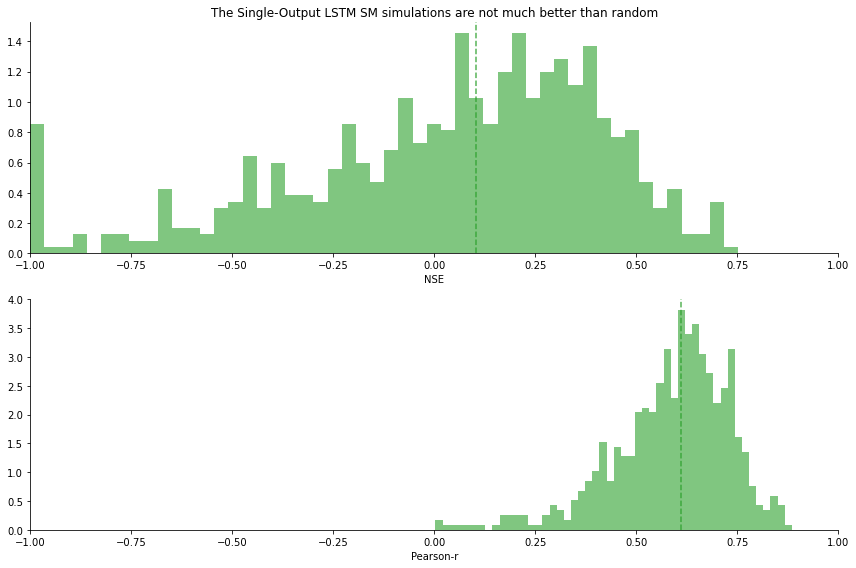

In [47]:
variable = "Pearson-r"
f, axs = plt.subplots(2, 1, figsize=(12, 4*2))

for i, variable in enumerate(["NSE", "Pearson-r"]):
    ax = axs[i]
    arr = finite_flat(sm_errors[variable])
    histogram_plot(np.clip(arr, -1, 1), hist_kwargs={"color": "C2"}, ax=ax)
    ax.set_xlabel(variable)
    ax.set_xlim(-1, 1)
    if i == 0:
        ax.set_title("The Single-Output LSTM SM simulations are not much better than random")

plt.tight_layout();

# Timeseries

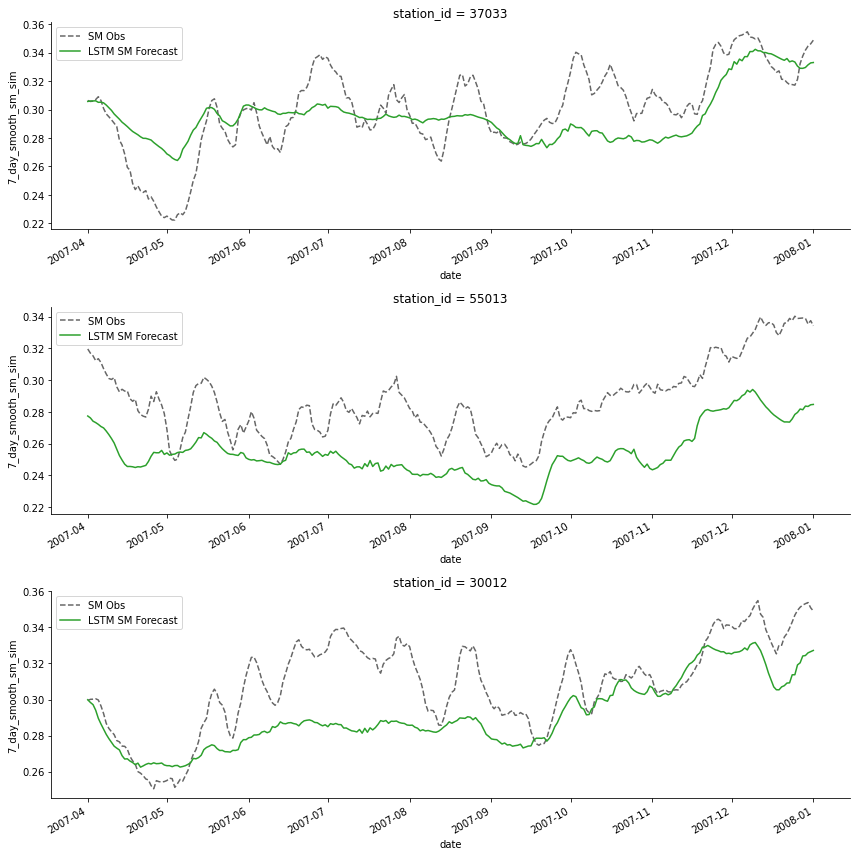

In [13]:
pixels = np.random.choice(preds.station_id.values, size=3)

times = slice("04-01-2007", "01-01-2008")

f, axs = plt.subplots(len(pixels), 1, figsize=(12, 4*len(pixels)))
for i, px in enumerate(pixels):
    ax = axs[i]
    preds.sel(station_id=px)[obs_var].sel(date=times).plot(ax=ax, color="k", alpha=0.6, ls="--", label="SM Obs")
    preds.sel(station_id=px)[sim_var].sel(date=times).plot(ax=ax, label="LSTM SM Forecast", color="C2")
    ax.legend()
    sns.despine()
    
plt.tight_layout();

# Spatial Errors

In [31]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

<AxesSubplot:>

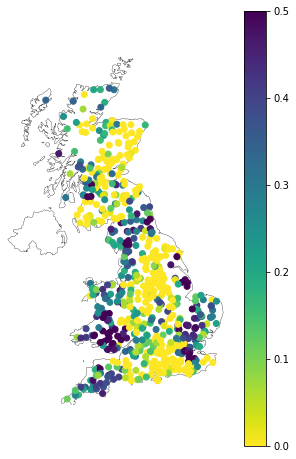

In [48]:
sm_errors["station_id"] = sm_errors["station_id"].astype(int)
gdf = gpd.GeoDataFrame(sm_errors.to_dataframe().join(points))

ax = initialise_gb_spatial_plot()
gdf.plot("NSE", vmin=0, vmax=0.5, ax=ax, cmap="viridis_r", legend=True)

# Unnormalize

In [27]:
[p for p in run_dir.glob("**/*.p")]
import pickle 

scaler = pickle.load((run_dir / "train_data/train_data_scaler.p").open("rb"))
scaler["xarray_feature_scale"][cfg.target_variables[0]]
scaler["xarray_feature_center"][cfg.target_variables[0]]

<xarray.DataArray '7_day_smooth_sm' ()>
array(0.27925152, dtype=float32)

In [21]:
(run_dir / "train_data/train_data_scaler.p")

PosixPath('/datadrive/data/runs/esa_cci_sm_SMOOTH_lstm_2106_153936/train_data/train_data_scaler.p')

In [28]:
from scripts.cell_state.analysis import (finite_flat, histogram_plot)

rescale = (preds - scaler["xarray_feature_center"][cfg.target_variables[0]]) / scaler["xarray_feature_scale"][cfg.target_variables[0]]
rescale

<xarray.Dataset>
Dimensions:              (date: 4018, station_id: 669)
Coordinates:
  * station_id           (station_id) <U6 '10002' '10003' ... '96004' '97002'
  * date                 (date) datetime64[ns] 1998-01-01 ... 2008-12-31
Data variables:
    7_day_smooth_sm_obs  (station_id, date) float64 0.05585 0.1478 ... 0.7898
    7_day_smooth_sm_sim  (station_id, date) float64 0.3837 0.399 ... 1.2 1.139

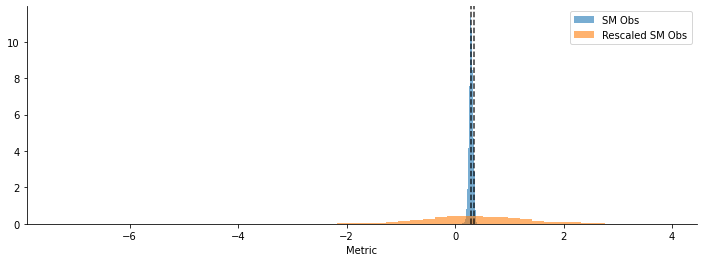

In [30]:
f, ax = plt.subplots(figsize=(12, 4))

histogram_plot(finite_flat(preds[obs_var].values), ax=ax, hist_kwargs={"label": "SM Obs"});
histogram_plot(finite_flat(rescale[obs_var].values), ax=ax, hist_kwargs={"label": "Rescaled SM Obs"});
plt.legend()